In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [149]:
df = pd.read_csv("passengers2.csv")

In [150]:
df.head()

,Month,reference,target,missing
0,1949-01-01,112,112.0,NaN
1,1949-02-01,118,118.0,NaN
2,1949-03-01,132,132.0,NaN
3,1949-04-01,129,NaN,129.0
4,1949-05-01,121,121.0,NaN


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   reference  144 non-null    int64  
 2   target     116 non-null    float64
 3   missing    28 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ KB


In [152]:
df['target'].isnull().sum()

28

In [153]:
# Метод 1: Восполнение предыдущими значениями
df['target_shift_filled'] = df['target'].copy()
mask = df['target'].isnull()
df.loc[mask, 'target_shift_filled'] = df['target'].shift(1)[mask]


In [154]:
df.head()

,Month,reference,target,missing,target_shift_filled
0,1949-01-01,112,112.0,NaN,112.0
1,1949-02-01,118,118.0,NaN,118.0
2,1949-03-01,132,132.0,NaN,132.0
3,1949-04-01,129,NaN,129.0,132.0
4,1949-05-01,121,121.0,NaN,121.0


In [155]:
# Метод 2.1: Скользящее среднее по формуле (window=3)
def manual_rolling_mean(series, window=3):
    result = series.copy()
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            start = max(0, i - window + 1)
            window_data = series.iloc[start:i]
            window_data = window_data.dropna()
            if len(window_data) > 0:
                result.iloc[i] = window_data.mean()
    return result

df['target_manual_rolling'] = manual_rolling_mean(df['target'], window=3)

# Метод 2.2: Скользящее среднее с помощью pandas
df['target_pandas_rolling'] = df['target'].copy()
df['target_pandas_rolling'] = df['target_pandas_rolling'].fillna(
    df['target'].rolling(window=3, min_periods=1).mean()
)

In [156]:
df.head()

,Month,reference,target,missing,target_shift_filled,target_manual_rolling,target_pandas_rolling
0,1949-01-01,112,112.0,NaN,112.0,112.0,112.0
1,1949-02-01,118,118.0,NaN,118.0,118.0,118.0
2,1949-03-01,132,132.0,NaN,132.0,132.0,132.0
3,1949-04-01,129,NaN,129.0,132.0,125.0,125.0
4,1949-05-01,121,121.0,NaN,121.0,121.0,121.0


In [157]:
# Метод 3.1: Линейная интерполяция по формуле
def linear_interpolation_formula(df):
    result = df['target'].copy()
    
    for i in range(len(df)):
        if pd.isna(result.iloc[i]):
            left_idx = i - 1
            while left_idx >= 0 and pd.isna(result.iloc[left_idx]):
                left_idx -= 1
            
            right_idx = i + 1
            while right_idx < len(df) and pd.isna(result.iloc[right_idx]):
                right_idx += 1
            
            if left_idx >= 0 and right_idx < len(df):
                x0, y0 = left_idx, result.iloc[left_idx]
                x1, y1 = right_idx, result.iloc[right_idx]
                x = i
            
                y = y0 + (y1 - y0) * (x - x0) / (x1 - x0)
                result.iloc[i] = y
    
    return result

df['target_formula_interp'] = linear_interpolation_formula(df)

# Метод 3.2: Интерполяция с помощью pandas
df['target_pandas_interp'] = df['target'].interpolate(method='linear')

In [158]:
df.head()

,Month,reference,target,missing,target_shift_filled,target_manual_rolling,target_pandas_rolling,target_formula_interp,target_pandas_interp
0,1949-01-01,112,112.0,NaN,112.0,112.0,112.0,112.0,112.0
1,1949-02-01,118,118.0,NaN,118.0,118.0,118.0,118.0,118.0
2,1949-03-01,132,132.0,NaN,132.0,132.0,132.0,132.0,132.0
3,1949-04-01,129,NaN,129.0,132.0,125.0,125.0,126.5,126.5
4,1949-05-01,121,121.0,NaN,121.0,121.0,121.0,121.0,121.0


In [160]:
# Метод 4.1: Простое экспоненциальное сглаживание по формуле
def exponential_smoothing_formula(series, alpha=0.3):

    smoothed = np.zeros(len(series))
    smoothed[0] = series.iloc[0]
    
    # Используем d = 0.3 (можно настроить)
    d = 0.5
    
    for t in range(1, len(series)):
        if pd.isna(series.iloc[t]):
            # Если значение пропущено, используем только предыдущее сглаженное
            smoothed[t] = d * smoothed[t-1]
        else:
            smoothed[t] = d * smoothed[t-1] + (1-d) * series.iloc[t]
    
    return smoothed

# Применяем к reference данным
df['reference_smoothed_formula'] = exponential_smoothing_formula(df['reference'], alpha=0.3)

# Метод 4.2: Экспоненциальное сглаживание с помощью pandas
df['reference_smoothed_pandas'] = df['reference'].ewm(alpha=0.3, adjust=False).mean()

In [161]:
df.head()

,Month,reference,target,missing,target_shift_filled,target_manual_rolling,target_pandas_rolling,target_formula_interp,target_pandas_interp,reference_smoothed_formula,reference_smoothed_pandas
0,1949-01-01,112,112.0,NaN,112.0,112.0,112.0,112.0,112.0,112.000,112.0000
1,1949-02-01,118,118.0,NaN,118.0,118.0,118.0,118.0,118.0,115.000,113.8000
2,1949-03-01,132,132.0,NaN,132.0,132.0,132.0,132.0,132.0,123.500,119.2600
3,1949-04-01,129,NaN,129.0,132.0,125.0,125.0,126.5,126.5,126.250,122.1820
4,1949-05-01,121,121.0,NaN,121.0,121.0,121.0,121.0,121.0,123.625,121.8274


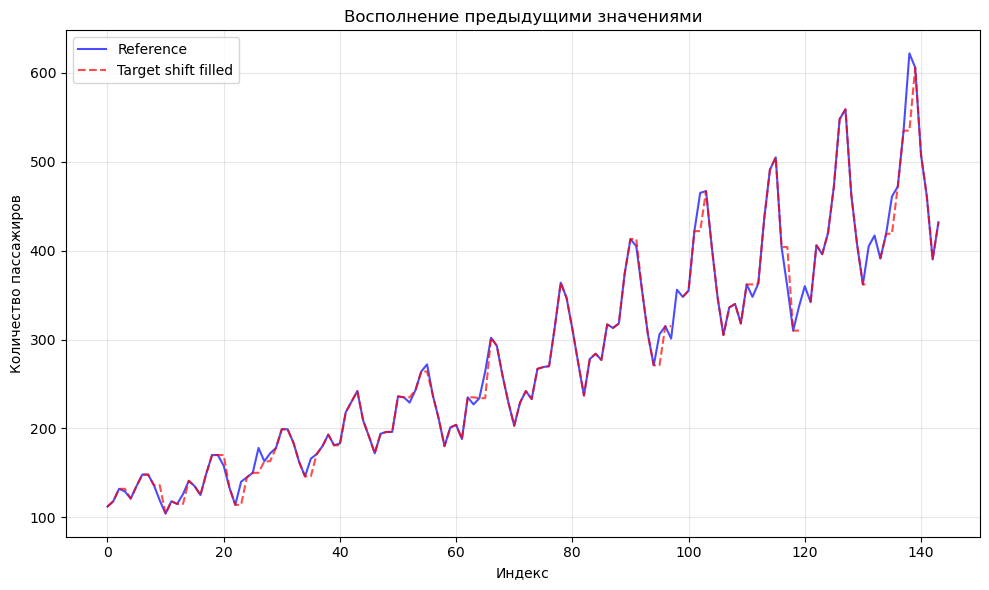

In [162]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['reference'], 'b-', label='Reference', alpha=0.7)
plt.plot(df.index, df['target_shift_filled'], 'r--', label='Target shift filled', alpha=0.7)
plt.xlabel('Индекс')
plt.ylabel('Количество пассажиров')
plt.title('Восполнение предыдущими значениями')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


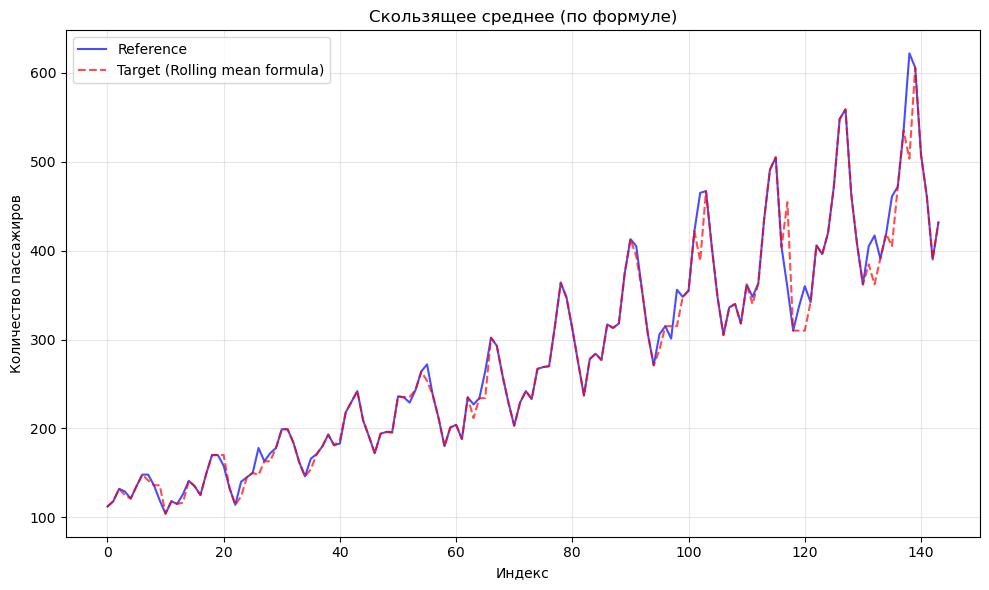

In [163]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['reference'], 'b-', label='Reference', alpha=0.7)
plt.plot(df.index, df['target_manual_rolling'], 'r--', label='Target (Rolling mean formula)', alpha=0.7)
plt.xlabel('Индекс')
plt.ylabel('Количество пассажиров')
plt.title('Скользящее среднее (по формуле)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

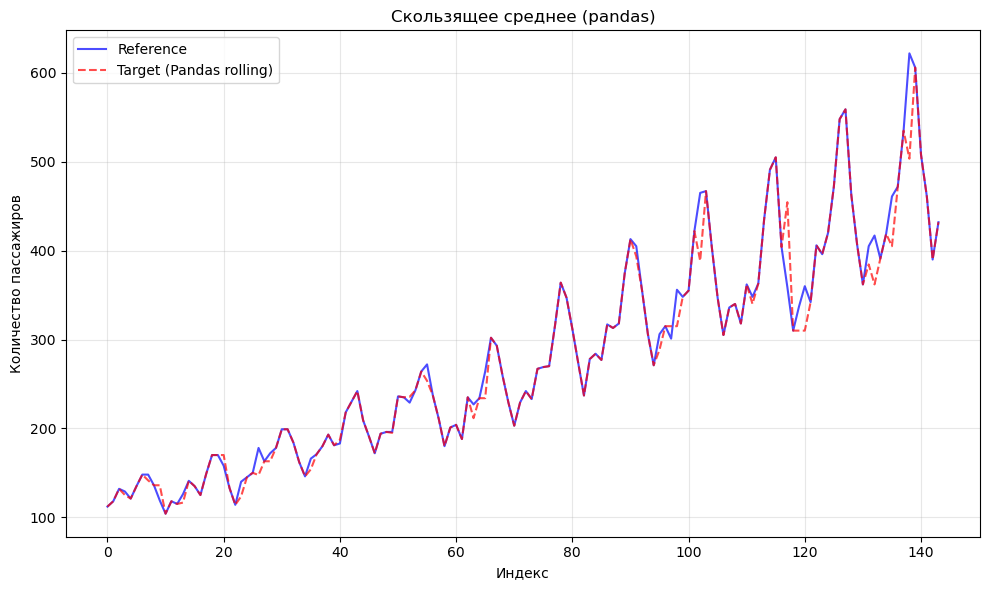

In [164]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['reference'], 'b-', label='Reference', alpha=0.7)
plt.plot(df.index, df['target_pandas_rolling'], 'r--', label='Target (Pandas rolling)', alpha=0.7)
plt.xlabel('Индекс')
plt.ylabel('Количество пассажиров')
plt.title('Скользящее среднее (pandas)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

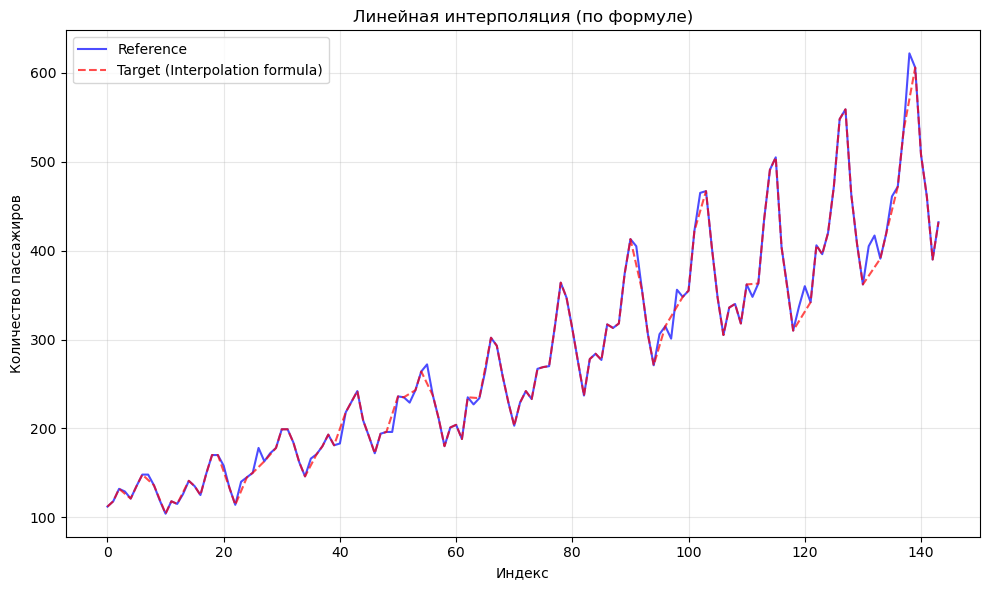

In [165]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['reference'], 'b-', label='Reference', alpha=0.7)
plt.plot(df.index, df['target_formula_interp'], 'r--', label='Target (Interpolation formula)', alpha=0.7)
plt.xlabel('Индекс')
plt.ylabel('Количество пассажиров')
plt.title('Линейная интерполяция (по формуле)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

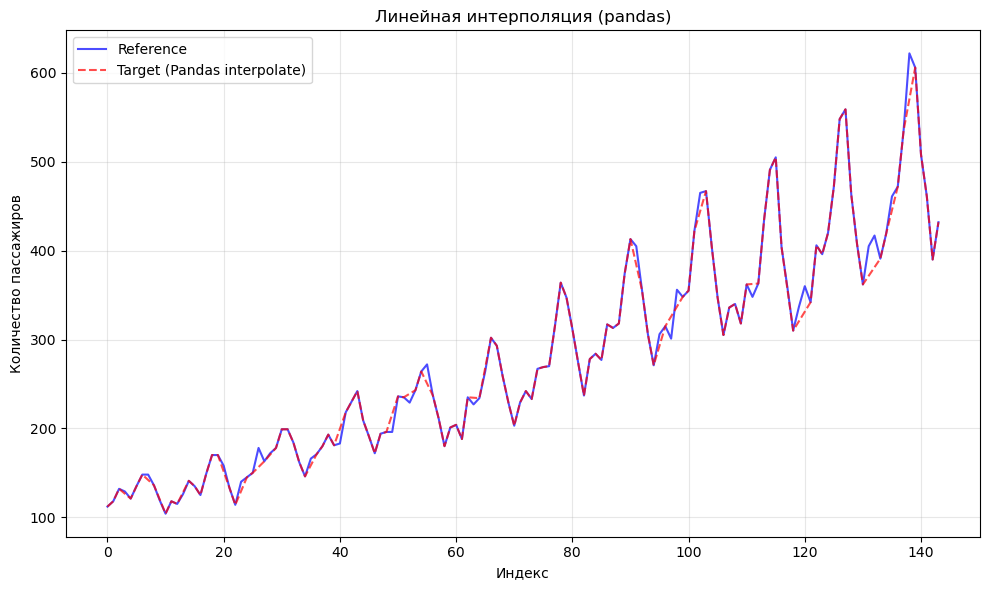

In [166]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['reference'], 'b-', label='Reference', alpha=0.7)
plt.plot(df.index, df['target_pandas_interp'], 'r--', label='Target (Pandas interpolate)', alpha=0.7)
plt.xlabel('Индекс')
plt.ylabel('Количество пассажиров')
plt.title('Линейная интерполяция (pandas)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


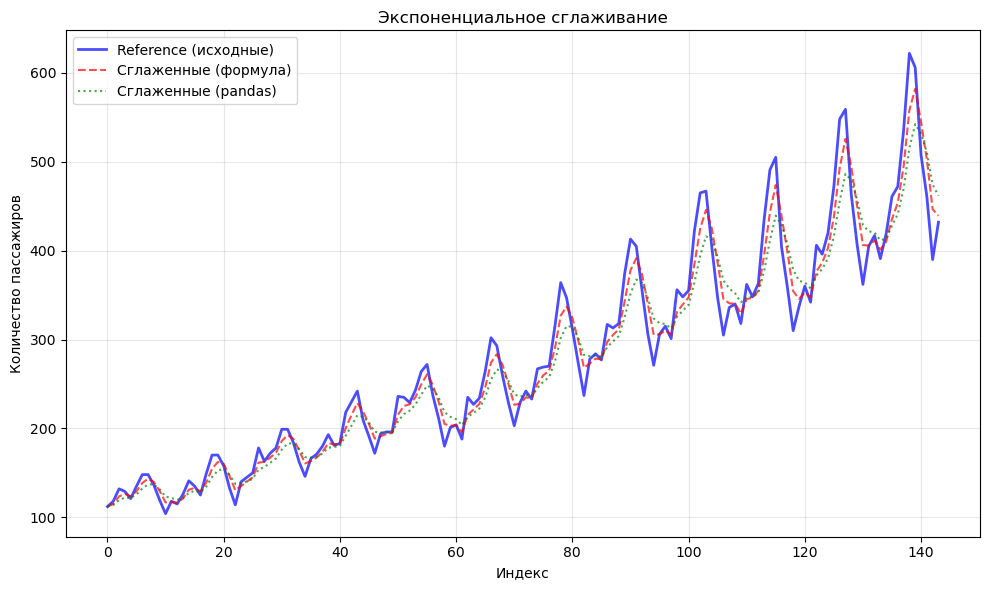

In [168]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['reference'], 'b-', label='Reference (исходные)', alpha=0.7, linewidth=2)
plt.plot(df.index, df['reference_smoothed_formula'], 'r--', label='Сглаженные (формула)', alpha=0.7)
plt.plot(df.index, df['reference_smoothed_pandas'], 'g:', label='Сглаженные (pandas)', alpha=0.7)
plt.xlabel('Индекс')
plt.ylabel('Количество пассажиров')
plt.title('Экспоненциальное сглаживание')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()